<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Signal Processing for Functional Brain Imaging Laboratories (MICRO-513)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Lab 3 - Graph Models</font></h1>

<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: May 20, 2021</p>
    <p style="margin:4px;"><b>Submission</b>: <span style="color:red">May 25, 2021</span> 
</div>

## Student Name: Emery Sébastien

## Student SCIPER: 258565

Welcome to the $3^{rd}$ and last graded lab of MICRO-513! After filling the previous cell with your information, run the next cell to make sure that you have all required Python libraries installed. Once you have done that, run the cell below it to import all the libraries you will be using, declare some useful functions and to set up your environment. 

In [1]:
!pip install networkx

In [2]:
#This section imports the needed libraries and defines the used functions:
import numpy as np, os
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import sklearn
from sklearn.svm import LinearSVC
plt.rcParams["figure.figsize"] = (12,8)

#View_A() for plotting the connectivity matrix
def View_A(X,labels, labels_on=True,size=14,grid=True):
    N=X.shape[0]
    plt.rcParams["figure.figsize"] = (size,size)
    plt.imshow(X, cmap="jet")
    plt.xlim([N,0])
    plt.ylim([0,N])
    plt.colorbar()
    if labels_on==False:
        labels=['']*X.shape[0]
    locs, labs = plt.xticks()           # Get locations and labels
    plt.xticks(np.arange(0,N), labels, rotation=90, fontsize=7)
    plt.yticks(np.arange(0,N), labels, fontsize=7)
    if grid==True:
        plt.grid(color='k', linestyle='-', linewidth=1.5)
    plt.show()

# ComputeC takes a binary adjacency matrix of size NxN as input and returns a N-element nodal clustering coefficient vector
def ComputeC(adj1):
    ccoefs = nx.algorithms.cluster.clustering(nx.convert_matrix.from_numpy_matrix(adj1.astype(int)))
    return np.asarray(list(ccoefs.values()))

# train_svm() for gender classification
def train_svm(X,labels):
    Err_test=0.
    Err_train_vec=np.zeros((X.shape[0],))
    for i in range(0,X.shape[0]):
        #split data into training and testing set (one sample)
        data_train=np.delete(X, i, 0)
        data_test=X[i,:].reshape(1, -1)
        C_train=np.delete(labels, i, 0).ravel()
        C_test=labels[i,:].reshape(1, -1)
        #train and predict
        model_svm_lin = LinearSVC(max_iter=5000)
        model_svm_lin.fit(data_train, C_train)
        C_pred_lin_test = model_svm_lin.predict(data_test)
        C_pred_lin_train = model_svm_lin.predict(data_train)
        Err_train_vec[i,] = np.sum(np.abs(C_pred_lin_train-C_train))*100/X.shape[0]
        if C_pred_lin_test!=C_test:
            Err_test += 1.
    
    Err_test=100*Err_test/X.shape[0]
    Err_train=np.mean(Err_train_vec)
    return Err_test, Err_train

# Graph Models

In this practical laboratory, you will be processing and analyzing data from the [*Human Connectome Project*](http://www.humanconnectomeproject.org/), a publicly available database of *fMRI* data. The experiment has the following characteristics:
 * All recordings are resting-state recordings from 27 male and 27 female subjects, all healthy volunteers aged 31-35 years. 
 * Data was acquired with a *TR* of 720 ms. 
 * As input to this laboratory, we consider the $nROI = 90$ region-wise, $nTP = 1190$ time points-long BOLD activity signals of the AAL atlas ([original paper [1]](https://d1wqtxts1xzle7.cloudfront.net/35799796/tzourio_NeuImg02.pdf?1417511685=&response-content-disposition=inline%3B+filename%3DTECHNICAL_NOTE_Automated_Anatomical_Labe.pdf&Expires=1609801063&Signature=g8DU5O3XvHVliT1U1uh~FRKzwWW8~uirSXoj6HLVOwx6NEi0mSafiuoMva~ekB-VXnwRQBOiXUYsO0wHsrWcXHoiszfw2KR-zjaQHFerkjeR7J-fNZDbCA6hbxshJeQMjgylrckDT~vPzwJScp9zlwx0TdIt5auZ4C3KRp~-GILQJ9HHQCVBH5-PJJwro96S295p3vgF43UE4~dXpEXJKYM9rlRUnlaSTRCZ8NYsQchKb-JWXWZkGVx426A8GrPUJp64RunO4G8Tv15BH21UYu4zI8hBJZoT2cI-0EjmGv5rhVu3UXACNsH~Bl0xko6W5qpStakugsB41-rXSXSGRg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)).

<!--
<div class = 'alert alert-success'>
    
**Note:** This Jupyter Notebook contains all the necessary code for the lab. To solve it, you will need to read and execute the following sections. Pay attention to comments in the code section as they explain the workflow. You will be graded with Multiple Choice Questions (*MCQ*), where you will have several possible answers, only one of them correct. 
    
Good luck! We hope you enjoy the lab. 
</div>
-->
<div class = 'alert alert-success'>
    
**Note:** In this laboratory you will be graded on a combination of Multiple Choice Questions (*MCQ*) and by filling some functions with code. To solve it, you will need to read and execute the following sections. Pay attention to comments in the code as they explain the workflow. 
    
Good luck! We hope you enjoy the lab. 
</div>

## Index
 1. [Implementation and Graph Construction](#1.-Implementation-and-Graph-Construction-(2-Points)) (**2 Points**)
 2. [Graph Metrics Evaluation](#2.-Graph-Metrics-Evaluation-(3-Points)) (**2 Points**)
 3. [Gender Classification](#3.-Gender-Classification-(2-Points)) (**2 Points**)

## 1. Implementation and Graph Construction (2 Points)

In this section we will construct a binary Adjacency Graph, parting from the time courses of one subject. For that, we will use the Pearson correlation coefficient as implemented in the function [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html), and then you will have to binarize this matrix.

First, run the next cell to load the data we will be working with. 

In [3]:
# Load brain region names
CBmat = scipy.io.loadmat("./LAB3_data/CB")
CB = CBmat['CB'].tolist()
CB = np.squeeze(np.asarray(CB).tolist())
# Load test adjacency matrix
Testmat = scipy.io.loadmat("./LAB3_data/Test")
Test = Testmat['Test'].tolist()
Test = np.squeeze(np.asarray(Test).tolist())
# Load all time courses per region per subject
TCSmat=scipy.io.loadmat("./LAB3_data/TCS")
TCS=TCSmat['TCS'].tolist()
TCS = np.squeeze(np.asarray(TCS).tolist())

Now, we start by filling in the `ComputeAdjacency()` function. This function takes the time courses of one subject as an argument, and returns a $90\times 90$ connectivity matrix reflecting the synchrony between time courses as computed by Pearson’s correlation coefficient. 

The function takes as a parameter:
 * `X` (NumPy Array): the time courses per region for ONE subject, i.e. a matrix of size 90x1190,

And returns as parameter:
 * `output` (NumPy Array): connectivity matrix of size $90\times 90$, where the entry $(i,j)$ corresponds to the correlation coefficient between $i_{th}$ and $j_{th}$ time course (rows of `X`). Diagonal values of the matrix should also be set to zero. 

<!---
<div alert = 'alert-alert info'>

**HINT**: Two functions that you might find useful are [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) and [`numpy.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)
<\div>--->

Run the next cell to declare this function.

In [4]:
def ComputeAdjacency(X):
    return np.corrcoef(X)-np.diag(np.diag(np.corrcoef(X)))

Now we will compute and visualize the obtained matrices for a few different subjects of the dataset, using the `View_A()` function we defined previously.

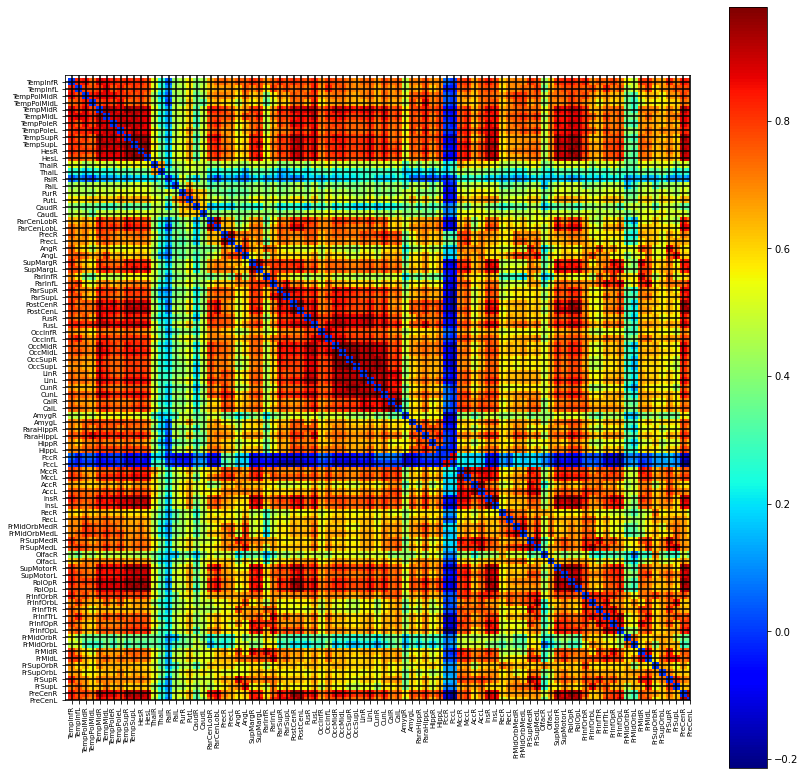

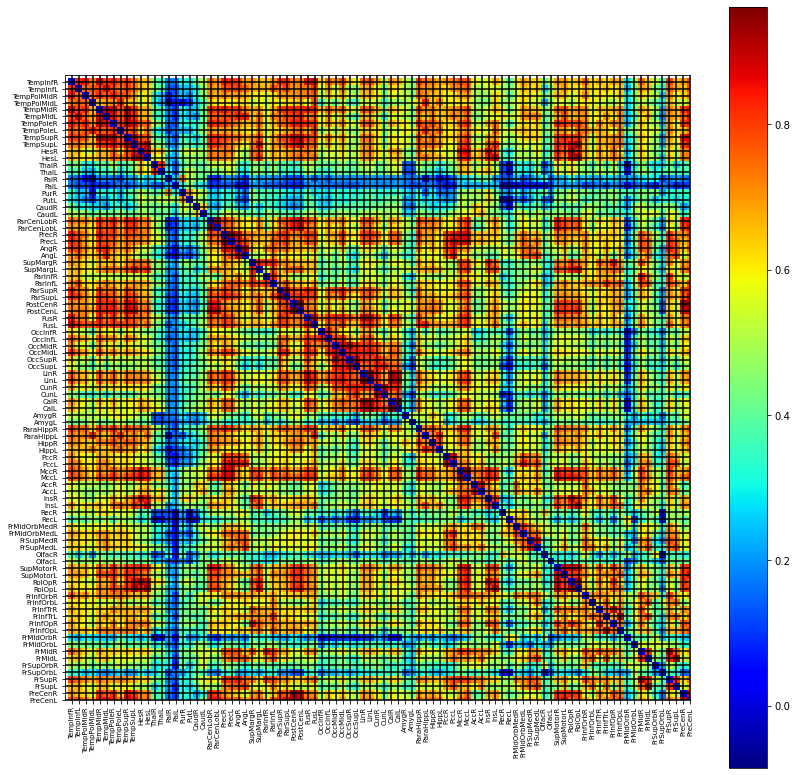

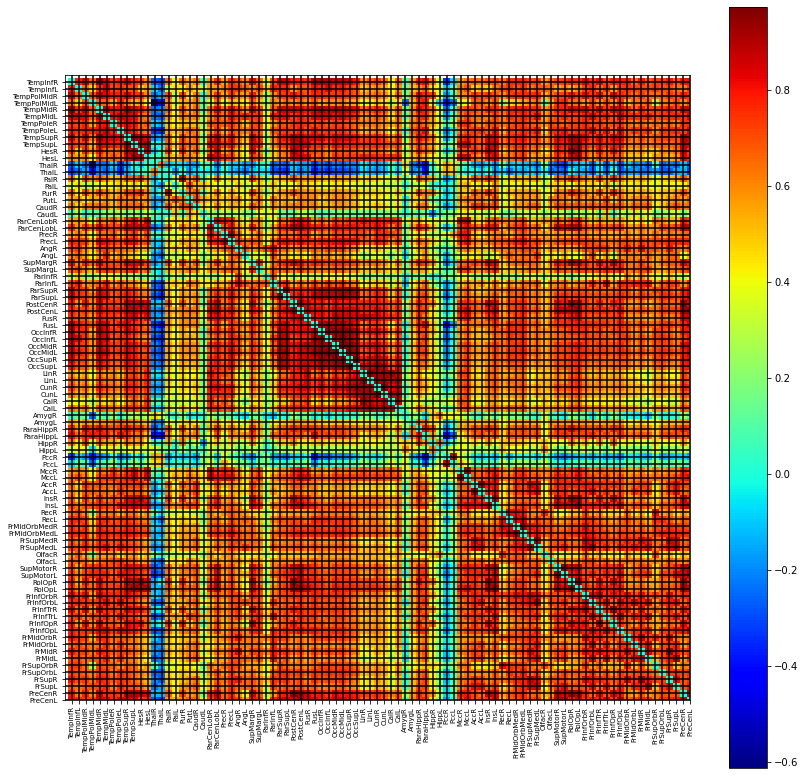

In [5]:
#This section computes and plots the adjacency matrices for three subjects
A_sub1 = ComputeAdjacency(TCS[0,:,:])
A_sub2 = ComputeAdjacency(TCS[1,:,:])
A_sub8 = ComputeAdjacency(TCS[7,:,:])
View_A(A_sub1,CB)
View_A(A_sub2,CB)
View_A(A_sub8,CB)

### Multiple Choice Question
Take a close look at the adjacency matrices plotted above (if you want to see matrices for other subjects, you can change the index of the first dimension of the variable `TCS`).

**For one point**, answer the following two *MCQ*s, worth 0.5 points each.

 * Q.1 What can we say about recurring patterns of functional connectivity? 

     1. There is no region that exhibits particularly strong or weak connectivity accross all subjects.
     2. There are some subcortical regions (*Put*, *Pal*, *Thal*) that exhibit widespread strong connectivity to all other brain areas.
     3. There is a core of occiptal regions (*Cal*, *Cun*, *Lin*, *OccSup*, *OccInf*) where correlation values are particularly strong in all subjects.
     4. All functional connections between cortical and subcortical regions are very similar across subjects.

To answer, change the value of the variable `answer_q1` in the next cell to reflect your choice. Then run the cell below it to check that your answer is valid.   

In [6]:
# Do not change the name of this variable
answer_q1 = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [7]:
assert answer_q1 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4.'

 * Q.2 What can we say about regions that exhibit weak connectivity to all other brain areas?

     1. These areas may be particularly dynamic in their interactions with other brain regions, resulting in low stationary correlation values (computed throughout all 1190 time points) because different subtypes of interaction (correlation, anti-correlation, independent rhythm) would occur at different time points.
     2.  Those particular brain regions will always fluctuate with high correlation in all subjects, possibly denoting a posterior visual resting-state system.
     3. There could be an enhanced ability to capture signals from these areas of the brain (higher *SNR* than for the rest of the brain) with the acquisition protocol employed in the Human Connectome Project. 

In the following cell, change the value of the variable `answer_q2` to reflect your choice. Then run the cell below it to check that your answer is valid.   

In [8]:
# Do not change the name of this variable
answer_q2 = 1
# YOUR CODE HERE
# raise NotImplementedError()

In [9]:
assert answer_q2 in [1, 2, 3], 'Valid answers are 1, 2, and 3.'

Before computing graph metrics, connectivity matrices need to be made binary. To do so, you will have to fill in the function `BinarizeAdjacency()`, which takes a non-binary $90\times 90$ connectivity matrix and a density fraction value (in the range $[0,1]$) as inputs, and returns a binary connectivity matrix. For example, a $0.5$ density value means that only the $50\%$ strongest connections must be retained in the output matrix. We have to be careful about the fact that we want to only consider the upper diagonal elements of the matrix (excluding diagonal elements themselves) for the calculations. 

**For 1 point, complete the code** of the function `BinarizedAdjacency`. The function takes as parameters:
 * `A` (2D NumPyArray): non-binary adjacency matrix A, and 
 * `rho` (scalar): the edge density
 
It returns `A2`, a connectivity matrix of the same size as `A`, where $\rho*100\%$ of the coefficients have been binarized to 1, and the rest to 0.

<div class = 'alert alert-info'>

**Note:** the function already includes certain lines of code at the beginning and the end of the body, respectively converting a matrix's upper entries into a vector, and converting a vector into a symmetric matrix.

**Hint:** You can use the function [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to sort the indices (pay attention to the default sorting type). 
</div>

In [10]:
def BinarizeAdjacency(A,rho):
    #Do not change the following three lines for extracting off-diagonal entries
    N = A.shape[0] #find the size of the matrix
    # Find the indices of the upper triangle
    ind = np.triu_indices(N, k=1)
    # Vectorize the element (strictly) above the main diagonal of the adjacency
    vec = A[ind] 
    # YOUR CODE HERE
    # raise NotImplementedError()
    # Binarize the vector vec, and keep the result in the variable vec2
    idx = np.argsort(vec)
    idx2 = np.argsort(idx)
    cutoff = vec.shape[0] - int(rho*vec.shape[0])
    vec2 = vec[idx]
    vec2[:cutoff] = 0
    vec2[cutoff:] = 1
    vec2 = vec2[idx2]
    
    # DO NOT CHANGE the following lines for converting a vector of off-diagonal entries into a matrix
    # Declare A2
    A2 = np.zeros((N,N))
    # Set upper triangle to the data of vec2
    A2[ind] = vec2
    # Add it to its transpose, to fill the lower triangle while
    A2=A2+A2.T
    # Make sure that the diagonal is filled with 0s
    A2 = A2 - np.diag(np.diag(A2))
    
    return A2

Test your implementation on the adjacency matrix from `Test.mat` MATLAB file that was loaded at the start of the script, using the `View_A()` function for visualization:

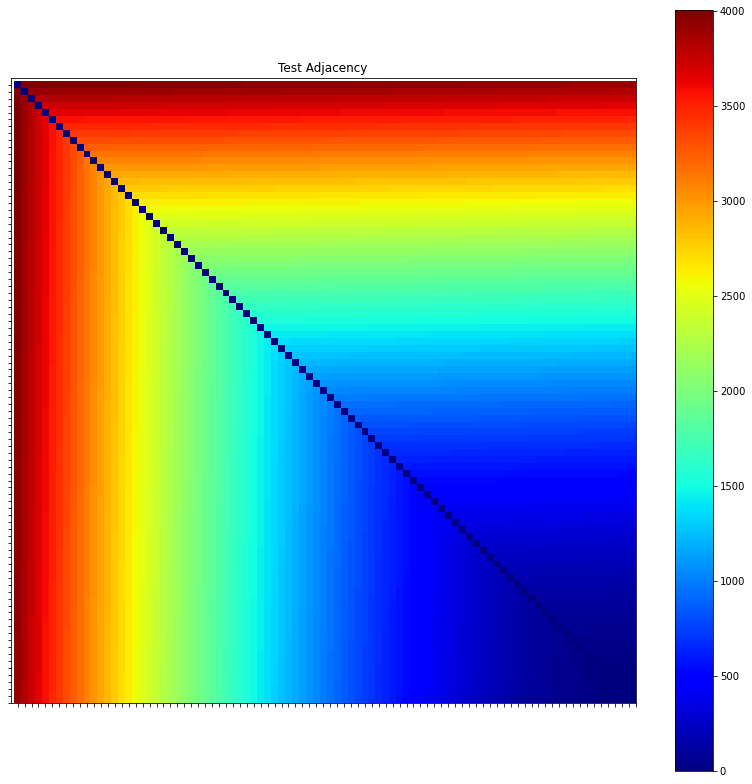

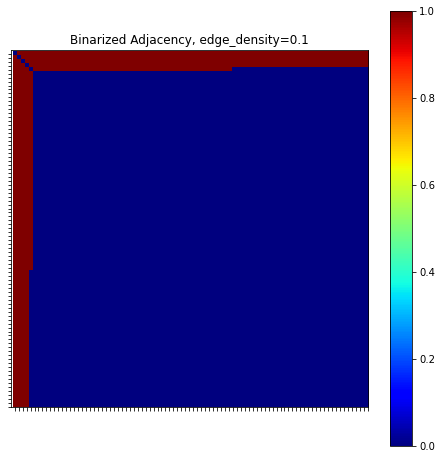

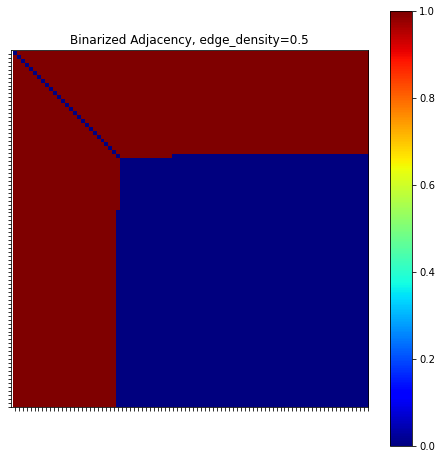

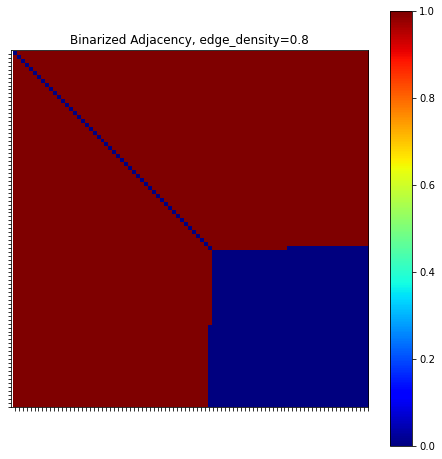

In [11]:
# First we calculate a few examples
TestBin10 = BinarizeAdjacency(Test,0.1)
TestBin50 = BinarizeAdjacency(Test,0.5)
TestBin80 = BinarizeAdjacency(Test,0.8)

# And plot them
plt.title("Test Adjacency")
View_A(Test,CB,size=8,labels_on=False,grid=False)
plt.title("Binarized Adjacency, edge_density=0.1")
View_A(TestBin10,CB,size=8,labels_on=False,grid=False)
plt.title("Binarized Adjacency, edge_density=0.5")
View_A(TestBin50,CB,size=8,labels_on=False,grid=False)
plt.title("Binarized Adjacency, edge_density=0.8")
View_A(TestBin80,CB,size=8,labels_on=False,grid=False)

## 2. Graph Metrics Evaluation (3 Points)
[Back to Index](#Index)

Now that we have **a** preprocessed and binarized the *Adjancency Matrix*, we need to evaluate it. The metric that we will mainly consider is the nodal clustering coefficient. Look back at your [course notes](https://moodle.epfl.ch/pluginfile.php/1676934/mod_resource/content/5/8-Connectomics.pdf) if needed to understand the mathematical definition, the value boundaries and the physiological interpretation of this brain connectivity measure.

For all subjects, we will compute the nodal clustering coefficient at different edge densities (from 0.05 to 0.95, by increments of 0.1). We use the function `ComputeC` to do so, defined at the biginning of the notebook. This function takes a binary adjacency matrix of size $N\times N$ as input and returns a $N$-element nodal clustering coefficient vector. It clusters using the implementation by *NetworkX* in `nx.algorithms.cluster.clustering`. Look at the [documentation](https://networkx.org/documentation/networkx-2.4/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html) for further details on this function.

Run the next cell to calculate the nodal clustering coefficient per node per adjacency matrix for every subject.

In [12]:
rho = np.zeros((10,1))
c = np.zeros((54,10,90))
for sub in range(0,54):
    for rho_ind in range(0,10):
        rho[rho_ind,0] = 0.1 * rho_ind + 0.05
        adj = BinarizeAdjacency(np.squeeze(ComputeAdjacency(TCS[sub,:,:])),rho[rho_ind,0])
        c[sub, rho_ind, :] = ComputeC(adj)
rho_vec = rho

Observe the outcome by plotting all the 90 nodal traces as a function of edge density for a few subjects. You can change the subjects by change the three numbers in the first for loop. Each line in the following plots corresponds to one of the 90 nodes in the graph.

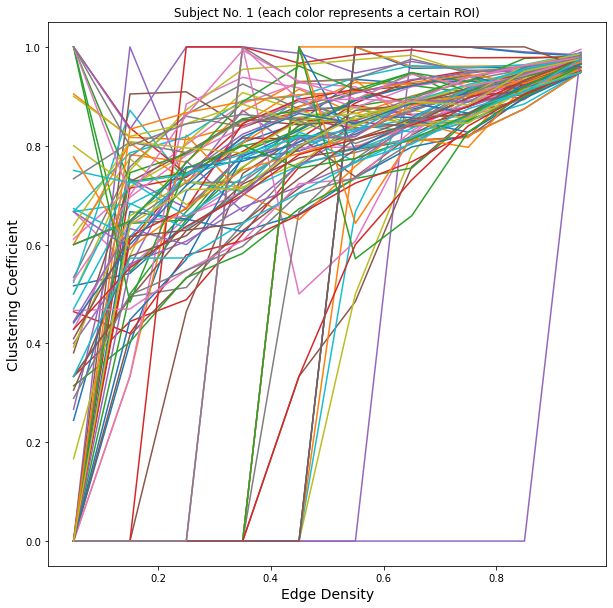

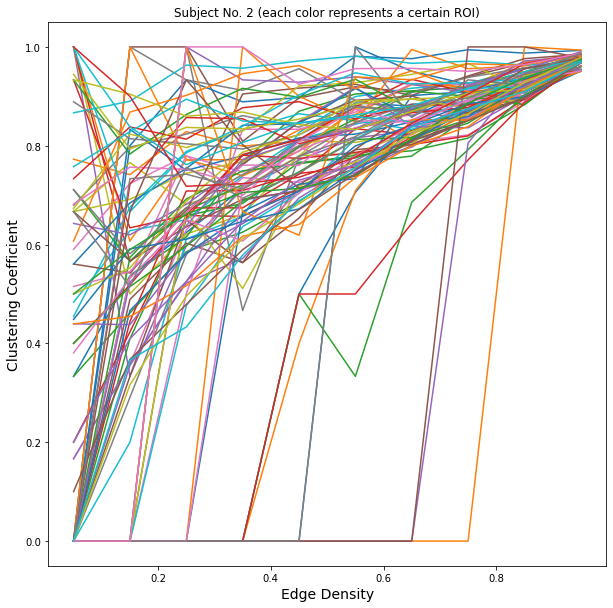

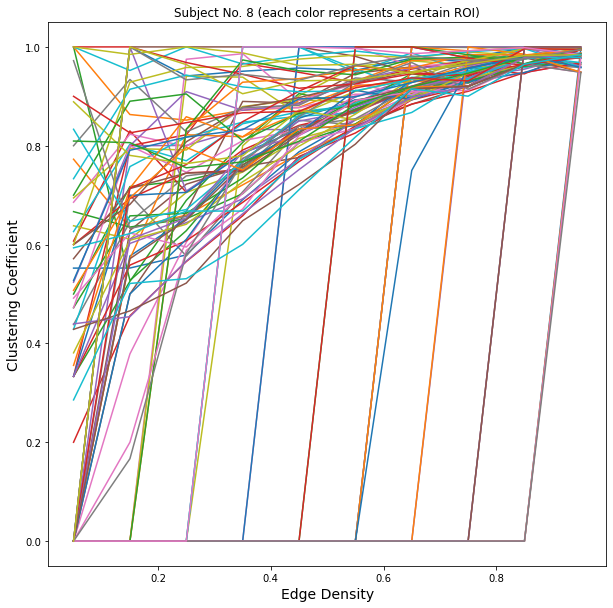

In [13]:
# Change the iterable to plot different subjects
for sub in [1, 2, 8]:
    plt.rcParams["figure.figsize"] = (10,10)
    # Iterate through each node and add to graph
    for node in range(0,90):
        plt.plot(rho, c[sub,:,node], label=str(node))
    # Format graph
    plt.xlabel("Edge Density",fontsize=14)
    plt.ylabel("Clustering Coefficient",fontsize=14)
    plt.title("Subject No. " + str(sub) + ' (each color represents a certain ROI)')
    plt.show()

### Multiple Choice Question

For **1 point**, answer the next *MCQ*. 

 * Q3. Why is it that for some regions, the clustering coefficient stays at zero until values of 0.4 - 0.7? This denotes the transition of...
 
 
  1. Two nodes that go from having no neighbors, to being neighbors with each other. 
  2. A node in question that suddenly gains neighbors that are already well connected to each other
  3. A node that gradually changes its closest neighbors.
 
To answer, change the value of the variable `answer_q3` in the next cell. Then run the cell below it to check the validity of your answer.

In [14]:
answer_q3 = 2
# YOUR CODE HERE
# raise NotImplementedError()

In [15]:
assert answer_q3 in [1, 2, 3], 'Valid answers are 1, 2 and 3.'

We will now try to compare the obtained results to the ones of a random graph
model with similar edge density. Using the function [`networkx.erdos_renyi_graph`](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html), which
takes as input parameters:
 * `n` (int): the number of nodes, and
 * `p` (float): the probability of connection, i.e. edge density.

It returns a graph structure.

Run the next two cells to generate a random graph of 90 nodes for the range of density values probed above. We will extract the adjacency matrix description of the graph, and compute the ratio between the subject-wise and the random nodal clustering coefficient values. Visualize the evolution of this parameter, for all nodes, with increasing edge density, averaging across subjects. 

In [16]:
# This sections calculates the clustering coefficient per node for random graphs
# with different edge densitiy (10 values between 0 and 1) and calculates the ratio between
# previously calculated clustering coefficients of brain networks and those of the random graphs (i.e. 
# normalized clustering coefficients)
c_rand = np.zeros((54,10,90))
for sub in range(0,54):
    counter=-1
    for edge_density in rho:
        counter += 1
        rand_graph = nx.erdos_renyi_graph(90, edge_density)
        # adj = rand_graph.adjacency()
        adj = nx.adjacency_matrix(rand_graph).todense()
        c_rand[sub, counter, :] = ComputeC(adj)
ratio = np.divide(c, c_rand, out=np.zeros_like(c), where=c_rand!=0)
c_average = np.mean(ratio, axis=0)

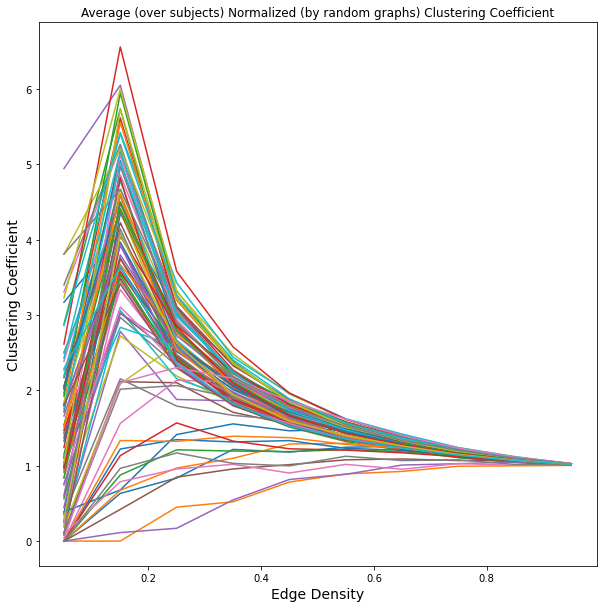

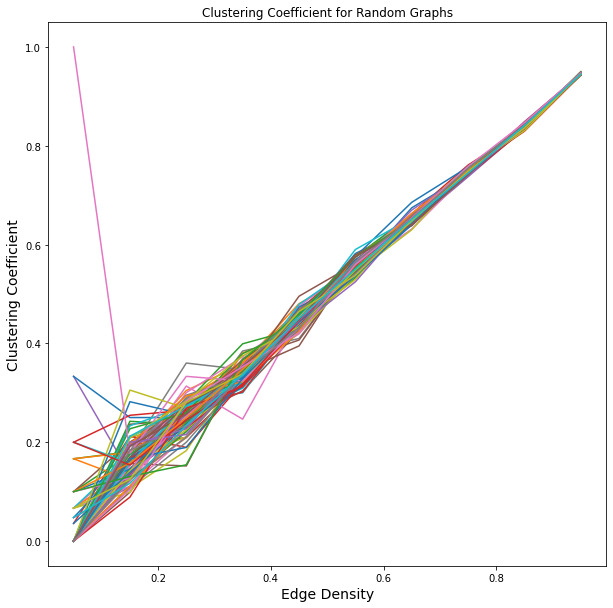

In [17]:
# This block plots the NORMALIZED clustering coefficient averaged over subjects versus edge density
# As before Each (color) line corresponds to one of the 90 nodes in the graph
plt.rcParams["figure.figsize"] = (10,10)
for node in range(0,90):
    plt.plot(rho, c_average[:,node], label=str(node))
plt.xlabel("Edge Density",fontsize=14)
plt.ylabel("Clustering Coefficient",fontsize=14)
plt.title("Average (over subjects) Normalized (by random graphs) Clustering Coefficient")
plt.show()

# This block plots the clustering coefficient versus edge density for a random graph
# Each (color) line corresponds to one of the 90 nodes in the graph
sub = 1
for node in range(0,90):
    plt.plot(rho, c_rand[sub,:,node], label=str(node))
plt.xlabel("Edge Density",fontsize=14)
plt.ylabel("Clustering Coefficient",fontsize=14)
plt.title("Clustering Coefficient for Random Graphs")
plt.show()

### Multiple Choice Question

**For 1 point**, answer the next *MCQ*.

 * Q3 What conclusion can you draw from this data regarding the functional architecture of the brain? What other analysis would be required to demonstrate that the brain is a *small world network?**
 
      1. Even if the ratio is bigger than 1 for very small edge densities, bigger edge densities yield more information about the architechture of the brain. We can readily see that by increasing the edge density, the brain architechture gets very similar to a random network architechture. The graph above is enough to demonstrate that the brain **is not** a *small world network*.
      2. The clustering coefficient for a random network increases with edge density, just as the clustering coefficient of the brain. This shows that the architecture of the brain is not ordered. However, we still need more information to make a claim about the size of the network. To make such a claim, we would need information on the efficiency of local information flow, and we would need to compute another graph metric, like closeness centrality.
      3. The fact that for small edge densities, the ratio of the real (measured) to random graph is much larger than $1$ is enough to claim that the brain is structured: Information flows more efficiently than in a random network. Thus, the brain is a *small world network*. 
      4. Answer $3$ plus we need to calculate the path length.
      5. Answer $4$ plus we need to calculate closeness centrality.
 
Change the value of the variable `answer_q4` in the next cell, and run the cell below it to check the validity of your answer.

In [18]:
answer_q4 = 4
# YOUR CODE HERE
# raise NotImplementedError()

In [19]:
assert answer_q4 in [1, 2, 3, 4,5], 'Valid answers are 1, 2 and 3.'

We will now observe what happens when nodes of the network are shut down in sequence. We will investigate two cases: 
 * one in which nodes are shut down in a random order (by setting the associated row/column of the connectivity matrix to null vectors), and 
 * one in which nodes are shut down starting with the ones exhibiting the larger degree. 
 
For an edge density of $0.3$, we will compute the average nodal clustering coefficient across nodes for each subject, incrementally removing a node at a time. 

Run the next cell to display the resulting curves, and compare both the random and specific shutting down cases.

In [20]:
# This cell performs node removal for each subject's adjacency matrix and at each step calculates
# the average (over nodes) clustering coefficient. This is repeated twice, for random node removal, and
# for removal of the node with the highest degree

rho = 0.3
c_rem = np.zeros((54,89))
c_rem_targ = np.zeros((54,89))
for sub in range(0,54):
    adj = BinarizeAdjacency(np.squeeze(ComputeAdjacency(TCS[sub,:,:])),rho).astype(int)
    adj_targ = adj
    for counter in range (1,90):
        node = np.random.randint(0, adj.shape[0])
        adj = np.delete(adj, node, 0)
        adj = np.delete(adj, node, 1)
        c_rem[sub, counter-1] = np.mean(ComputeC(adj))
        #ccoefs = nx.algorithms.cluster.clustering(nx.convert_matrix.from_numpy_matrix(adj))
        #c_rem[sub, counter-1] = np.mean(np.asarray(list(ccoefs.values())))
        
        deg = adj_targ.dot(np.ones(adj_targ.shape[0],))
        node = np.argmax(deg)
        adj_targ = np.delete(adj_targ, node, 0)
        adj_targ = np.delete(adj_targ, node, 1)
        c_rem_targ[sub, counter-1] = np.mean(ComputeC(adj_targ))
        #ccoefs = nx.algorithms.cluster.clustering(nx.convert_matrix.from_numpy_matrix(adj_targ))
        #c_rem_targ[sub, counter-1] = np.mean(np.asarray(list(ccoefs.values())))

Now run the next cell to plot the node-averaged clustering coefficient versus number of nodes removed. 

<div class = 'alert alert-info'>
    
**Note:** Each subject's graph corresponds to two lines: one *blue-ish* for random node removal, and one *red-ish* for highest degree node removal.
</div>

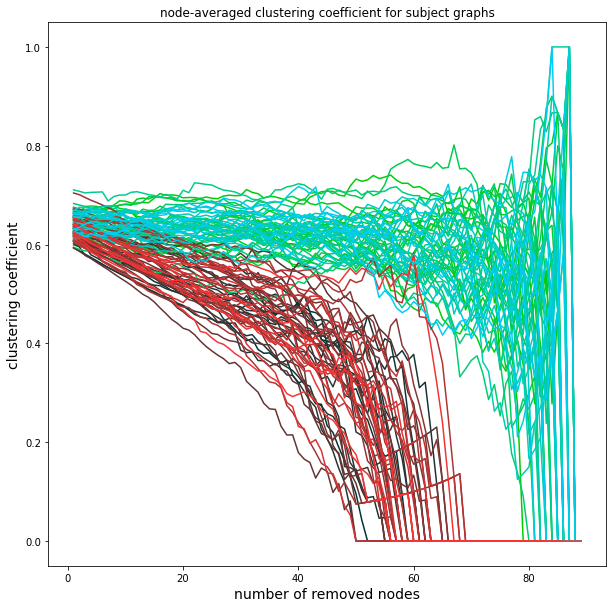

In [21]:
plt.figure()
for sub in range(0,54):
    plt.plot(np.arange(1,90), c_rem[sub,:], color=[0,0.8,sub/54])
    plt.plot(np.arange(1,90), c_rem_targ[sub,:], color=[sub/54,0.2,0.2])
plt.xlabel("number of removed nodes",fontsize=14)
plt.ylabel("clustering coefficient",fontsize=14)
plt.title("node-averaged clustering coefficient for subject graphs")
plt.show()

### Multiple Choice Question

For **1 point**, answer the following *MCQ*.

 * Q5: What can you conclude after looking at how the node-averaged clustering coefficient changes when you start removing nodes?
 
      1. The fact that targeted removal reaches zero faster is a strong indicator that the brain is not modular.
      2. Both targeted and random removals can lead to zero clustering coefficients in the above plot. It shows that functional brain connectivity is very close to a random network.
      3. The changes in clustering coefficient don't tell us anything about the brain
      4. There is a subset of brain regions that are particularly important to maintain correct functional architecture. 

To answer, change the value of the variable `answer_q5`, and then run the following cell to test the validity of your answer.

In [22]:
answer_q5 = 4
# YOUR CODE HERE
# raise NotImplementedError()

In [23]:
assert answer_q5 in [1, 2, 3, 4,], 'Valid answers are 1, 2 and 3.'

# 3. Gender Classification (2 Points)
[Back to Index](#Index)

We will now attempt to use a linear Support Vector Machine (*SVM*) framework in order to classify male and female subjects from our dataset according to their brain connectivity feature. This is a task that has already been undertaken by previous research work [see original paper](https://www.sciencedirect.com/science/article/pii/S105381191001058X). 

For this purpose, we resort to a leave-one-out cross-validation (*LOOCV*) framework with labels $0$ and $1$ for male and female subjects, respectively. In the present data, the first 27 subjects are male, and the second half of subjects are female.

Look back at your [course notes](https://moodle.epfl.ch/pluginfile.php/1674937/mod_resource/content/6/7-PR.pdf) if you need to, and remember the principles of *LOOCV* and the reasons why it has to be used in this case. Also, briefly summarize the working principle of the linear SVM classification approach.

As a first trial, we will attempt to classify our subjects on the basis of nodal clustering coefficient data: each data point is thus a 90-dimensional feature vector. For density values ranging from 0.05 to 0.95 by increments of 0.1, we compute the training and testing *LOOCV* errors, and plot the two output curves. We will use the function `train_svm` we declared at the beginning of the notebook.

Run the next cell to vlasify our subjects and plot the two error curves with respect to the edge density.

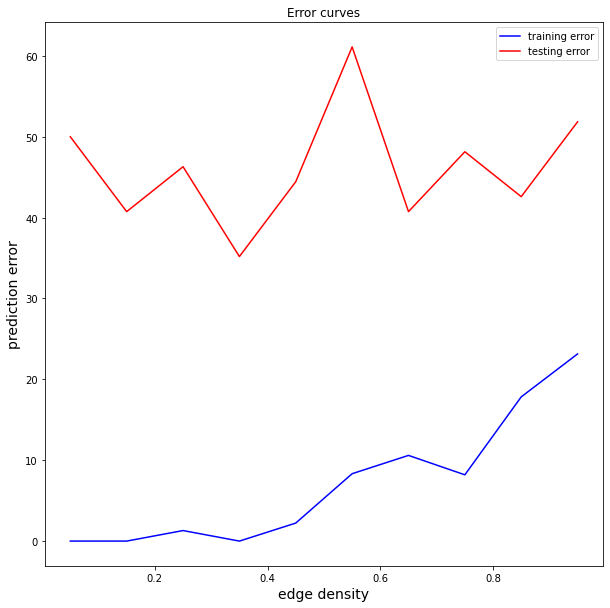

In [24]:
# This section performs LOOCV gender classification using linear SVM and clustering coefficient as features
etrain, etest = np.zeros((10,1)), np.zeros((10,1))
for rho_ind in range(0,10):
    X = np.squeeze(c[:, rho_ind, :])
    labels = np.zeros((X.shape[0],1))
    labels[27:,0] = 1

    etest[rho_ind,0], etrain[rho_ind,0] = train_svm(X,labels)

plt.figure()
plt.plot(rho_vec, etrain,'b', label="training error")
plt.plot(rho_vec, etest,'r', label="testing error")
plt.legend()
plt.xlabel("edge density",fontsize=14)
plt.ylabel("prediction error",fontsize=14)
plt.title('Error curves')
plt.show()

### Multiple Choice Question

For **1 point**, answer the following *MCQ*. 

* Q6. Look closely at the plot above, and choose the wrong statement.

 1. There is only one specific edge density at which the classification error in the testing stage is below the chance level.
 2. The quality of the classification varies with edge density.
 3. There is at least one specific edge density for which flipping a coin would give you a better classification.
 4. There is a clear overfitting for low edge densities.
 
Modify the variable `answer_q6` in the next cell, and then run the cell below it to check the validity of your choice. 

In [25]:
answer_q6 = 1
# YOUR CODE HERE
# raise NotImplementedError()

In [26]:
assert answer_q6 in [1, 2, 3, 4]

Now, we want to instead use functional connectivity values themselves for classification purposes. We extract them from the subject-wise connectivity matrices, and compute training and testing errors in this case. 

Run the next cell to perform this classification and see the results.

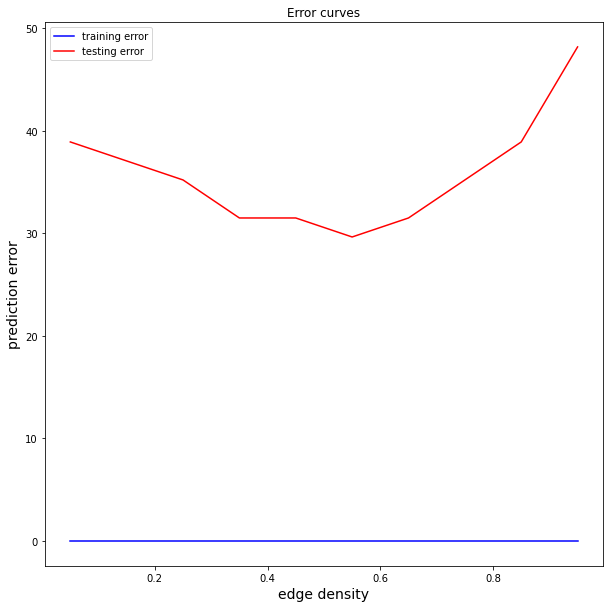

In [27]:
#This section performs LOOCV classification into male and female subjects
#using linear SVM and vectorized functional connectivity matrices as features
etrain, etest = np.zeros((10,1)), np.zeros((10,1))
for rho_ind in range(0,10):
    #build data matrix from functional connectivity
    X=np.zeros((54,90*90))
    for sub in range(0,54):
        adj = BinarizeAdjacency(np.squeeze(ComputeAdjacency(TCS[sub,:,:])),rho_vec[rho_ind,0])
        X[sub,:]=adj.reshape(1,-1)
    labels=np.zeros((X.shape[0],1))
    labels[27:,0]=1

    etest[rho_ind,0], etrain[rho_ind,0] = train_svm(X,labels)

#This section plots the two error curves with respect to the edge density
plt.figure()
plt.plot(rho_vec, etrain,'b', label="training error")
plt.plot(rho_vec, etest,'r', label="testing error")
plt.legend()
plt.xlabel("edge density",fontsize=14)
plt.ylabel("prediction error",fontsize=14)
plt.title('Error curves')
plt.show()

### Multiple Choice Question

For your **last point** of the lab, answer the following MCQ.
* Q7. Which of the following statements can explain the behaviour observed in the graph above?

    1. SVM is not an appropriate classifier for this kind of problem, because it gives near chance level results.
    2. SVM clearly classifies subjects based on their gender, as we can see from the above plot where the training accuracy is much higher than the chance level. 
    3. We should have applied a feature selection step before SVM training in order to reduce the risk of overfitting. The 0% error in the training set is due to clear overfitting. 

Change the value of the variable `answer_q7` to answer. Then run the cell below it to check that your answer is valid. 

In [28]:
answer_q7 = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [29]:
assert answer_q7 in [1, 2, 3]

<div class = 'alert alert-success'>

Congratulations on finishing the and $3^{rd}$ and last graded lab! Don't forget to hand it in. 
</div>

### References
1. [Tzourio-Mazoyer, N., et al., *Automated anatomical labeling of activations in SPM using a macroscopic anatomical parcellation of the MNI MRI single-subject brain*. Neuroimage, 2002. 15(1): p. 273-89.](https://d1wqtxts1xzle7.cloudfront.net/35799796/tzourio_NeuImg02.pdf?1417511685=&response-content-disposition=inline%3B+filename%3DTECHNICAL_NOTE_Automated_Anatomical_Labe.pdf&Expires=1611098460&Signature=Q~C90QGXUSzes6tlqI7NM0ajt9RWaJGZ6PkYn5Ixl5b3RMPbEtns-MclNI6RvNr4c2IFdJCvstqPrnMzP4PH9aRTK86GD7NujbkV2oW6ukclQogsFwoZKwRm7vFGmKBiLDasAhVjivEtXjHGMZ4XwfaN1OglLJJkFaFDfA-P12Bwg5pryqLlltun1gg0VBKWJz5buoj0swOKbxBXqC2MUBW6DaqLCYO~D1KP650qHSLembUjQdUYaOHba8vsVtQuwG7JTQ0LJEZ3IUcEfspwG-BdZVEmGPzYJU-LGs2whH72meYEHL5eMRDW0yX6T-vZoDdeys5BCuSEC65Hd4f4WA__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)
2. [Tian, L., et al., *Hemisphere- and gender-related differences in small-world brain networks: a resting-state functional MRI study*. Neuroimage, 2011. 54(1): p. 191-202.](https://www.sciencedirect.com/science/article/pii/S105381191001058X?casa_token=3thtiV931QIAAAAA:HXAGTK-ijTCpKNpy6L6Zb-9iA8a3T22ixoxnBnpEB3PyXt4bwzdV1HcVloVk1X-uml2qFpE)